In [1]:
from scipy.signal import filtfilt
from scipy.signal import butter,lfilter
from scipy.signal import freqs,freqz
import numpy as np
from scipy.fft import fft,ifft,fftfreq
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import hilbert
from scipy import signal
%matplotlib inline
from plotly import __version__
from statsmodels.tsa.ar_model import AutoReg 
import ipywidgets as widgets
from obspy.signal.trigger import recursive_sta_lta,carl_sta_trig,plot_trigger#,trigger_onset
from obspy.core.trace import Trace
from collections import deque 
from obspy.signal.trigger import ar_pick

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):#band pass filter using butter worth method
    '''returns the coeffecients for an nth order bandpass filter
    lowcut,highcut:- cutoff frequency
    fs:- sampling frequency
    order:-order if the filter
    output 
    a,b:- poles and zeros for the transfer function
    '''
    nyq = 0.5 * fs#nyquist frequency
    low = lowcut / nyq 
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')#parameters for filters/filter coefficients/coeff of digital transfer fn
    return b, a# coefficients of numerator and denomenator polynomial

In [3]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):#band pass filter using butter worth method
    '''returns the filtered data for a given data
    data:-original data
    lowcut,highcut:- cutoff frequency
    fs:- sampling frequency
    order:-order if the filter
    
    output
    y:filtered data 
    '''
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)# coefficients of numerator and denomenator polynomial
    y = lfilter(b, a, data)#fir filter
    return y#filtered data

In [4]:
def data_pack(X_data):
    '''data pack is used to create an envelope around the original readings of the accelerometer 
    X:- original data'''
    y = butter_bandpass_filter(X_data,0.001,2,810,order=5)# band pass filter between 5 and 7 hrtz
    y=abs(y)# to convert negative data from accelerometer to positive value 
    y_max=np.max(y)# max value recorded by accelerometer
    y_envelop=np.zeros_like(y)
    y_envelop_2=np.zeros_like(y)
    y_envelop[:]=(y[:]/y_max)-(y[:]/y_max)**2# a variable to almost map the original wave but with less ossciliations
    for i in range(1,len(y)):
        y_envelop_2[0]=y_envelop[0]
        y_envelop_2[i]=np.max(y_envelop[i-1:i+1])#to reduce the osscilations even further and make the data more uniform 
    y_hilbert=np.imag(hilbert(y_envelop_2))
    return y,y_hilbert, y_envelop_2

reading and processing data to make data easier to process

In [5]:
my_step=pd.read_csv('elcentro.csv')# reading data 
X=my_step['Acceleration']# accelerometer reading
X=X+100

plt.figure(figsize=(10,7))
freq,psd=signal.welch(rec_data[1],40.5)# spectral density plot using welch method
plt.plot(freq,psd,'b.-')#plotting psd using welches method
plt.xlabel('frequency')
plt.ylabel('power spectral density')
#b, a = butter(10, 0.1, btype='low', analog=False)
y,y_hilbert,y_envelop_2=data_pack(X)
plt.figure(figsize=(10,7))

plt.plot(my_step['Time'],X)
plt.ylabel('processed accelerometer data')
plt.xlabel('time')


NameError: name 'rec_data' is not defined

<Figure size 720x504 with 0 Axes>

Text(0, 0.5, 'processed accelerometer data')

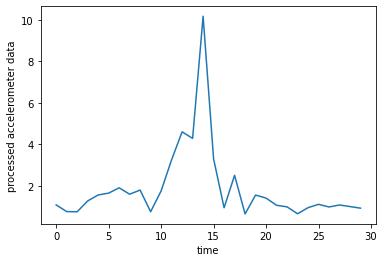

In [7]:
SENSOR=pd.read_csv('SensorsData.csv')
Stime=SENSOR['Time']-SENSOR['Time'][0]
Sx=SENSOR['X']
Sy=SENSOR['Y']
Sz=SENSOR['Z']
Sdata=(Sx**2+Sy**2+Sz**2)**(1/2)
S,S_hilbert,S_envelop=data_pack(Sdata)
plt.plot(Sdata)
plt.xlabel('time')
plt.ylabel('processed accelerometer data')

In [108]:
def trigger_onset(charfct, thres1, thres2, max_len=9e99, max_len_delete=False):#to determine when the event is triggred and di triggered 
    '''function returns the indices of the the points where a trigger onset is detected  and the offset of wave is considered 
    charfct:- ratio(sta,lta)
    threst1,2 threshold for wave onset and offset
    output:
    pick:- the indices at wich an event is hapening
    '''
    ind1 = np.where(charfct > thres1)[0]# for points when magnitude is above thresh 1 
    if len(ind1) == 0:
        return []
    ind2 = np.where(charfct > thres2)[0]# for points when magnitude is above thresh 2
    trigger_on = deque([ind1[0]])# for points when magnitude is above thresh 1
    trigger_of = deque([-1])
    # determine the indices where charfct falls below off-threshold
    ind2_ = np.empty_like(ind2, dtype=bool)
    ind2_[:-1] = np.diff(ind2) > 1# to give true for points where trigger goes below thresh 2 after the magnitude increases above thresh 1 
    # last occurence is missed by the diff, add it manually
    ind2_[-1] = True
    trigger_of.extend(ind2[ind2_].tolist())# to create an array which stores point where the the event ends 
    trigger_on.extend(ind1[np.where(np.diff(ind1) > 100)[0] + 1].tolist()) # to create an array which stores the point where the event starts 
    # include last pick if trigger is on or drop it
    if max_len_delete:# in case max_len_delete is true
        # drop it
        trigger_of.extend([1e99])
        trigger_on.extend([on[-1]])
    else:
        # include it
        trigger_of.extend([ind2[-1]])
    #
    pick = []
    while trigger_on[-1] > trigger_of[0]: # some boundry conditions to avoid some conflicts 
        while  trigger_on[0] <=  trigger_of[0]:
               trigger_on.popleft()# for because in case the value of sta/lta is greater than thresh 1 from the get go and can provide false triggers
        while  trigger_of[0] <  trigger_on[0]:
             trigger_of.popleft() # to remove the cases where the value is greater than thr 2 but not than thr 1 to avoid false triggers
        if  trigger_of[0] -  trigger_on[0] > max_len:
            if max_len_delete:
                trigger_on.popleft()
                continue
            trigger_of.appendleft( trigger_on[0] + max_len)
        pick.append([ trigger_on[0],  trigger_of[0]])
    return np.array(pick, dtype=np.int64)


In [109]:
def trigger_event(thr_on,thr_off,k_or,k,k_envelop_2,k_hilbert,sta_time=1,lta_time=60,df=1):
    '''
    returns the processed data in which only the data with event is diplayed
    thr_on,off:= threshold for wave onset and offset
    k_or,k,K_envelop_2,K_hilbert:- data and its processed form 
    lta,sta_time:- length of short time,long time window
    output:
    even:- an array that returns the actual even or set of events
    len(on_off):-no of events present in the data
    on,off:- points at which event starts and ends
    '''
    ratio_sta_lta=np.zeros(len(k))
    sta=0.#short term average 
    csta=1./sta_time# variable to reduce redudancy in writting the formula 
    clta=1./lta_time# variable to reduce redudancy in writting the formula 
    icsta=1-csta# variable to reduce redudancy in writting the formula 
    iclta=1-clta# variable to reduce redudancy in writting the formula 
    lta=1e-99# long term average 
    for i in range(len(k_envelop_2)):
        k_new=np.sqrt((k_envelop_2[i]**2)+(k_hilbert[i]**2))#value manipulation using hilber method
        sta=k_new*csta+icsta*sta
        lta=k_new*clta+iclta*lta
        if(i<lta_time):
            ratio_sta_lta[i]=0
        else:
            ratio_sta_lta[i]=sta/lta
    cft=ratio_sta_lta
    plt.plot(cft)
    trace=Trace(np.array(k_or))
    npts = trace.stats.npts
    t = np.arange(npts, dtype=np.float32) / df
    cft1=np.array(cft)
    on_off = np.array(trigger_onset(cft1, thr_on, thr_off))
    even=np.zeros(len(k_or))
    on=on_off[:,0]
    off=on_off[:,1]
    for i in range (0,len(on_off)):
        even[on[i]-1:off[i]]=k_or[on[i]-1:off[i]]
    return even,len(on),on,off

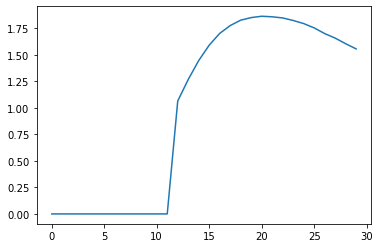

In [10]:
event,length,on_sensor,off_sensor=trigger_event(0.01,0.001,Sdata,S,S_hilbert,S_envelop,3,12)

In [11]:
def energy(event3,length3,on3,off3,time_event=0):
    '''
    event3:- the data of an event
    length3:- no of events in the given data
    on3,off3:-  points at which event starts and ends
    output: 
    energy4 the energy of the diffrent events 
    '''
    energy4=np.zeros(length3)
    for j in range(length3):
        e3=np.array(event3)
        recfreq=np.fft.fftfreq(np.shape(e3)[0],d=1/810)
        ffta=np.zeros(shape=(np.size(recfreq)))
        ffta[:]=abs((np.fft.fft(e3))**2)
        energy4[j]=np.dot(recfreq**2,ffta[:])
    return energy4

In [12]:
 def time_of_arrlival(time_event,on_event):
        '''
        calculates the time of arrival of wave for a reciever
        time= input time data
        on_event=calculate from trigger_event
        
        '''
        toa=np.zeros(len(on_event,on_event[0]))
        toa=time_event[on_event]
        return toa

In [13]:
energy1=energy(event,length,on_sensor,off_sensor)

In [14]:
print(energy1)

[ 78967443.20175293]


Text(0, 0.5, 'processed accelerometer data')

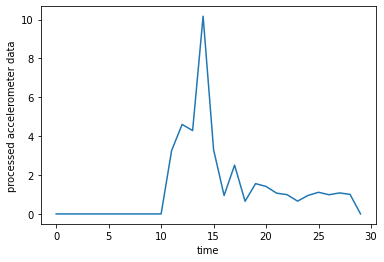

In [15]:
plt.plot(event)
plt.xlabel('time')
plt.ylabel('processed accelerometer data')

# data being exported and converted to arrar

In [16]:
recx_data=np.array(pd.read_csv('recx_data.csv'))
recy_data=np.array(pd.read_csv('recy_data.csv'))
recz_data=np.array(pd.read_csv('recz_data.csv'))


In [24]:
a=ar_pick(recz_data[0],recx_data[0],recy_data[0],81,0.001,2,120,30,150,60,5,100,5,810)

In [25]:
a

(-5.0, 0.0)

# converting the data from all 3 axis by vector addition and consedring just magnitude

In [26]:
rec_data=np.zeros_like(recx_data)
for i in range(len(recx_data)):
    for j in range(len(rec_data[i])):
        rec_data[i][j]=np.sqrt(recx_data[i][j]**2+recy_data[i][j]**2+recz_data[i][j]**2)

# data packing

In [27]:

time=np.linspace(0,1,810)
rec_data1=np.zeros_like(rec_data)
rec_data_envelop=np.zeros_like(rec_data)
rec_data_hilbert=np.zeros_like(rec_data)
for i in range(100):
    rec_data1[i],rec_data_envelop[i],rec_data_hilbert[i]=data_pack(rec_data[i])

### z

In [28]:

time=np.linspace(0,1,810)
recz_data1=np.zeros_like(rec_data)
recz_data_envelop=np.zeros_like(rec_data)
recz_data_hilbert=np.zeros_like(rec_data)
for i in range(100):
    recz_data1[i],recz_data_envelop[i],recz_data_hilbert[i]=data_pack(recz_data[i])

### y

In [29]:

time=np.linspace(0,1,810)
recy_data1=np.zeros_like(rec_data)
recy_data_envelop=np.zeros_like(rec_data)
recy_data_hilbert=np.zeros_like(rec_data)
for i in range(100):
    recy_data1[i],recy_data_envelop[i],recy_data_hilbert[i]=data_pack(recy_data[i])

### z

In [30]:

time=np.linspace(0,1,810)
recx_data1=np.zeros_like(recx_data)
recx_data_envelop=np.zeros_like(recx_data)
recx_data_hilbert=np.zeros_like(recx_data)
for i in range(100):
    recx_data1[i],recx_data_envelop[i],recx_data_hilbert[i]=data_pack(recx_data[i])

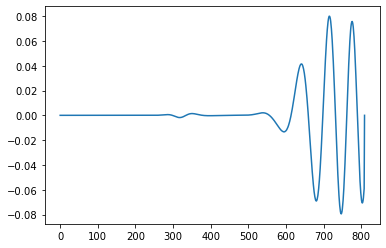

In [31]:
plt.plot(recz_data[20])

# energy calculation and event detection for all 3 axis as well as for combined data

In [32]:
rec_datadiff=rec_data[:]-rec_data[-1:]

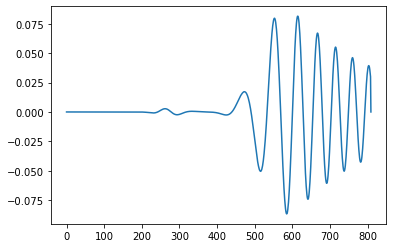

In [33]:
plt.plot(recz_data[90])

In [82]:
on_shit=np.zeros(len(rec_data))
for i in range(len(rec_data)):
    for j in range(len(rec_data[0])):
        if recz_data[i][j]>0.000000000001:
            on_shit[i]=j
            break

            

In [83]:
on_shit

array([ 121.,  113.,  186.,  128.,  108.,   19.,  156.,  137.,  102.,
        178.,   63.,  194.,   91.,   83.,  171.,  105.,  147.,  113.,
        161.,  131.,  200.,   81.,  184.,  117.,  116.,  163.,   52.,
        109.,  184.,  159.,  194.,  162.,  135.,  162.,  209.,   48.,
        150.,   94.,   48.,  145.,  170.,  152.,  174.,  181.,  164.,
        123.,  227.,  176.,  181.,  141.,   89.,  173.,   67.,   85.,
        124.,  174.,   95.,   63.,  147.,  113.,   40.,  181.,   71.,
         26.,  151.,  107.,  168.,  176.,  109.,  130.,  142.,   98.,
         46.,  196.,    9.,  161.,  149.,  142.,  121.,  115.,  134.,
        177.,  153.,  162.,   74.,   74.,  147.,  164.,  176.,   88.,
        150.,  168.,  101.,  108.,   69.,  157.,  126.,  116.,   85.,  123.])

In [84]:
time[int(on_shit[1])]-time[int(on_shit[0])]

-0.0098887515451174246

In [85]:
dist=np.zeros(100)
for i in range(100):
    dist[i]=(time[int(on_shit[i])]-time[int(on_shit[0])])*2000

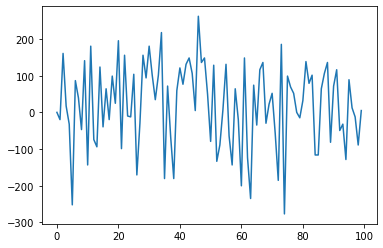

In [86]:
plt.plot(dist)

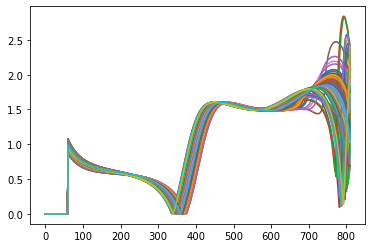

In [127]:
event1=np.zeros_like(rec_data)
length1=np.zeros(100)
on1=[]
off1=[]
energy2=[]
for i in range(100):
    event2,length2,on2,off2=trigger_event(1,0.0,rec_data[i],rec_data1[i],rec_data_envelop[i],rec_data_hilbert[i],1,60)
    event1[i]=event2
    length1[i]=length2
    energy3=energy(event2,length2,on2,off2,time)
    energy2.append(energy3)
    on1.append(on2)
    off1.append(off2)
energy2=np.array(energy2)
energy_rec_tot=energy2.reshape(len(energy2[0]),len(energy2))


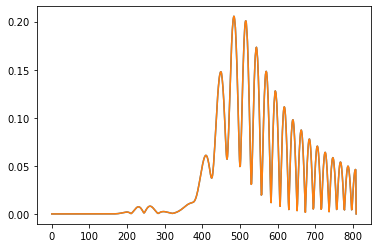

In [90]:
plt.plot(event1[0])
plt.plot(rec_data[0])

In [91]:
on1,off1

([array([60], dtype=int64),
  array([60], dtype=int64),
  array([415], dtype=int64),
  array([60], dtype=int64),
  array([60], dtype=int64),
  array([420], dtype=int64),
  array([409], dtype=int64),
  array([405], dtype=int64),
  array([60], dtype=int64),
  array([414], dtype=int64),
  array([401], dtype=int64),
  array([418], dtype=int64),
  array([394], dtype=int64),
  array([394], dtype=int64),
  array([415], dtype=int64),
  array([385], dtype=int64),
  array([407], dtype=int64),
  array([60], dtype=int64),
  array([412], dtype=int64),
  array([406], dtype=int64),
  array([418], dtype=int64),
  array([396], dtype=int64),
  array([416], dtype=int64),
  array([60], dtype=int64),
  array([60], dtype=int64),
  array([412], dtype=int64),
  array([397], dtype=int64),
  array([60], dtype=int64),
  array([416], dtype=int64),
  array([413], dtype=int64),
  array([417], dtype=int64),
  array([411], dtype=int64),
  array([408], dtype=int64),
  array([411], dtype=int64),
  array([420], dtype=in

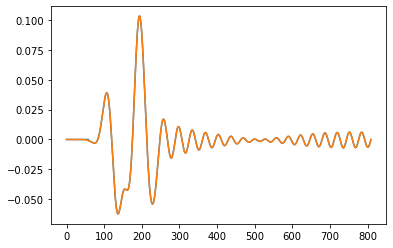

In [103]:
plt.plot(eventx[5])
plt.plot(recx_data[5])

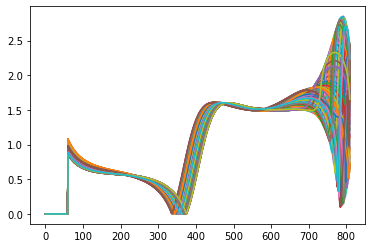

In [126]:
eventx=np.zeros_like(rec_data)
lengthx=np.zeros(100)
onx=[]
offx=[]
energyx=[]
for i in range(100):
    event2_x,length2_x,on2_x,off2_x=trigger_event(0.4,0,recx_data[i],recx_data1[i],recx_data_envelop[i],recx_data_hilbert[i],1,60)
    eventx[i]=event2_x
    lengthx[i]=length2_x
    energy3_x=energy(event2_x,length2_x,on2_x,off2_x,time)
    energyx.append(energy3_x)
    onx.append(on2_x)
    offx.append(off2_x)
energyx=np.array(energyx)
energy_rec_x=energyx.reshape(len(energyx[0]),len(energyx))

In [112]:
ony


[array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 

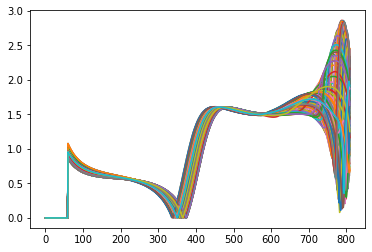

In [125]:
eventy=np.zeros_like(rec_data)
lengthy=np.zeros(100)
ony=[]
offy=[]
energy1y=[]
for i in range(100):
    event2_y,length2_y,on2_y,off2_y=trigger_event(0.4,0,recy_data[i],recy_data1[i],recy_data_envelop[i],recy_data_hilbert[i],1,60)
    eventy[i]=event2_y
    lengthy[i]=length2_y
    energy3=energy(event2_y,length2_y,on2_y,off2_y,time)
    energy1y.append(energy3)
    ony.append(on2_y)
    offy.append(off2_y)
energy_rec_y=np.zeros_like(energy1y)
energy1y=np.array(energy1y)
energy_rec_y=energy1y.reshape(len(energy1y[0]),len(energy1y))

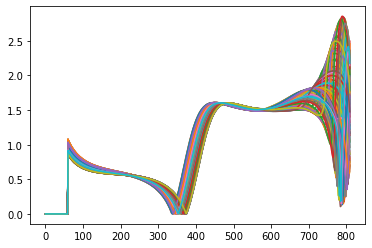

In [123]:
eventz=np.zeros_like(rec_data)
lengthz=np.zeros(100)
onz=[]
offz=[]
energyz=[]
for i in range(100):
    event2_z,length2_z,on2_z,off2_z=trigger_event(0.4,0,recz_data[i],recz_data1[i],recz_data_envelop[i],recz_data_hilbert[i],1,60)
    eventz[i]=event2_z
    lengthz[i]=length2_z
    energy3=energy(event2_z,length2_z,on2_z,off2_z,time)
    energyz.append(energy3)
    onz.append(on2_z)
    offz.append(off2_z)
energyz=np.array(energyz)
energy_rec_z=energyz.reshape(len(energyz[0]),len(energyz))


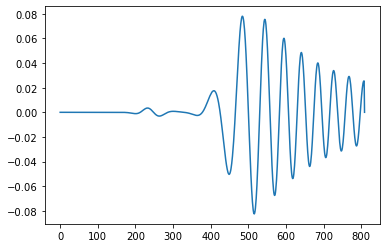

In [33]:
plt.plot(recz_data[0])

In [115]:
onz

[array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 array([60], dtype=int64),
 

In [476]:
on1=np.array(onz)
on_ev=on1.reshape(len(onz))

ValueError: cannot reshape array of size 200 into shape (100,)

In [ ]:
plt.plot(recz_data[0])

Text(0, 0.5, 'energy')

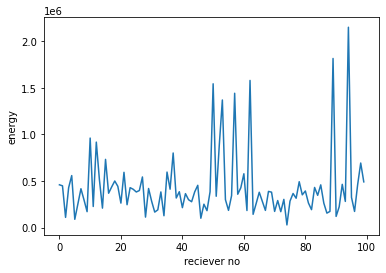

In [128]:
plt.plot(energy_rec_tot[0])
plt.xlabel("reciever no")
plt.ylabel("energy")

Text(0, 0.5, 'energy in x')

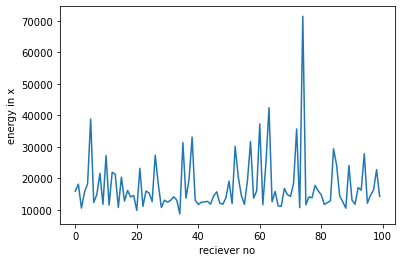

In [129]:
plt.plot(energy_rec_x[0])
plt.xlabel("reciever no")
plt.ylabel("energy in x")

Text(0, 0.5, 'energy in y')

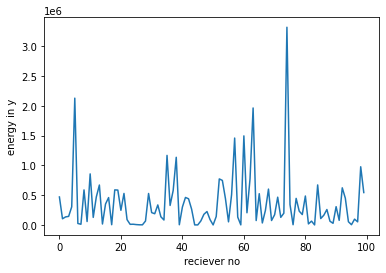

In [130]:
plt.plot(energy_rec_y[0])
plt.xlabel("reciever no")
plt.ylabel("energy in y")

Text(0, 0.5, 'energy in z')

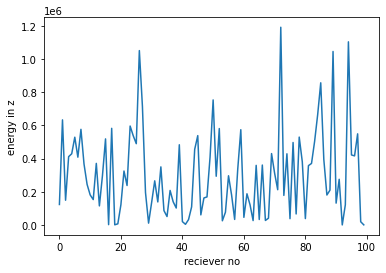

In [131]:
plt.plot(energy_rec_z[0])
plt.xlabel("reciever no")
plt.ylabel("energy in z")

In [132]:
on_tot=np.zeros(len(on1))

In [419]:
np.mean(abs(recz_data[0][on1[0][1]]/rec_data[0][on1[0][1]]))

0.053659390775707375

In [465]:
for i in range(len(on1)):
    on_tot[i]=time[np.min([on1[i][1],onx[i][1],ony[i][1],onz[i][1]])]
    

# trying to calculate the an average acceleration for event 

# trying to establish a relationship between energy of wave and distance between reciever and source(incunclusive)

In [466]:

@widgets.interact(p=(2,3,0.001),k=(0.1,1,0.001))
def n_val(p,k):
    n=[]
    dist=[]
    for i in range(len(energy_rec_tot[0])):
        n.append((1/(k*(energy_rec_tot[0,i]/energy_rec_tot[0,0])**p))-1)
        dist.append(2*(time[np.min([on1[i][0],onx[i][0],ony[i][0],onz[i][0]])]-time[np.min([on1[0][0],onx[0][0],ony[0][0],onz[0][0]])]))
    global dist1,n1
    dist1=np.zeros(len(energy_rec_tot[0]))
    n1=(1/(k*(energy_rec_tot[0,:]/energy_rec_tot)**p))-1
    for j in range(len(energy_rec_tot[0])):
        dist1[j]=dist[j][0]

    plt.plot(abs(dist1),(1/((energy_rec_tot[0,:]/energy_rec_tot[0,0])**p))-1)

interactive(children=(FloatSlider(value=2.0, description='p', max=3.0, min=2.0, step=0.001), FloatSlider(value…

In [467]:
on_tot

array([ 0.52657602,  0.52657602,  0.52657602,  0.52904821,  0.52410383,
        0.5315204 ,  0.5315204 ,  0.52904821,  0.52657602,  0.52781211,
        0.52904821,  0.52904821,  0.5315204 ,  0.5315204 ,  0.52904821,
        0.52904821,  0.52904821,  0.52904821,  0.52410383,  0.52657602,
        0.5315204 ,  0.5315204 ,  0.52657602,  0.52904821,  0.52904821,
        0.52657602,  0.52657602,  0.52410383,  0.52904821,  0.52410383,
        0.52781211,  0.5315204 ,  0.5315204 ,  0.5315204 ,  0.5315204 ,
        0.52657602,  0.5315204 ,  0.5315204 ,  0.52410383,  0.52904821,
        0.52904821,  0.5315204 ,  0.52904821,  0.52781211,  0.52904821,
        0.52410383,  0.5315204 ,  0.52410383,  0.52904821,  0.5315204 ,
        0.52410383,  0.52904821,  0.52904821,  0.5315204 ,  0.52781211,
        0.52904821,  0.5315204 ,  0.52904821,  0.5315204 ,  0.52657602,
        0.52533993,  0.52533993,  0.52904821,  0.5315204 ,  0.5315204 ,
        0.52657602,  0.52904821,  0.52904821,  0.52657602,  0.52

In [470]:
dist=np.zeros(len(on_tot))
for i in range(len(on_tot)):
    dist[i]=(on_tot[i]-on_tot[0])*20000
    

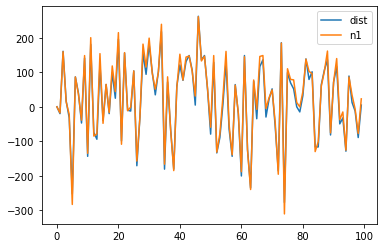

In [87]:
#plt.plot(abs(dist1))
plt.plot(dist)
plt.plot(dist_act-dist_act[0])
plt.legend(['dist','n1'])
#plt.scatter(dist1,(energy2[2:,0])**1/2)
#a=np.polyfit(dist1,energy2[2:,0],10)
#b=np.polyval(a,dist1)

<ipython-input-88-3ad47c4b0ceb>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((dist_act-dist_act[0])/dist)
<ipython-input-88-3ad47c4b0ceb>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((dist_act-dist_act[0])/dist)


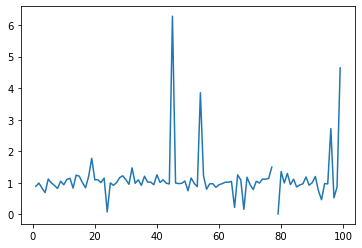

In [88]:
plt.plot((dist_act-dist_act[0])/dist)

In [177]:
a=np.polyfit(np.log(abs(dist1[1:])),np.log(abs((energy_rec_tot[0][1:]/energy_rec_tot[0][0]))),1)

NameError: name 'dist1' is not defined

In [34]:
a

array([ 0.20382418, -1.207775  ])

# calculation of angle between reciever and source(failed)

In [35]:
energyx=np.array(energyx)

In [36]:
energy1y=np.array(energy1y)

In [37]:
energyz=np.array(energyz)


In [38]:
accx,accy,accz=net_acceleration_event(eventx,eventy,eventz,on1,off1,length2)


In [39]:
theta=np.arctan(energy1y/energyx)
phi=np.arccos(accz/(accx**2+accy**2+accz**2)**(1/2))

[array([ 0.33170507]), array([ 0.49469878]), array([ 0.59767182]), array([ 1.63026156]), array([ 4.80902479]), array([ 24.23914398]), array([ 24.52606357]), array([ 36.6538037]), array([ 46.09850734]), array([ 49.80641854]), array([ 56.25531618]), array([ 61.68428772]), array([ 66.3065783]), array([ 67.00109614]), array([ 67.86944236]), array([ 69.39178526]), array([ 70.66057016]), array([ 72.17158191]), array([ 72.32512049]), array([ 74.38321376]), array([ 75.79570567]), array([ 77.01101624]), array([ 77.09808052]), array([ 77.64088345]), array([ 77.67907852]), array([ 78.09982864]), array([ 78.93648136]), array([ 78.95655778]), array([ 79.45767419]), array([ 80.05634792]), array([ 80.4516244]), array([ 81.21688201]), array([ 81.83661873]), array([ 82.10263092]), array([ 82.19337134]), array([ 82.54484405]), array([ 82.62051197]), array([ 82.80173158]), array([ 82.88646261]), array([ 83.46105507]), array([ 83.51595083]), array([ 83.94503708]), array([ 84.03389498]), array([ 84.0558487

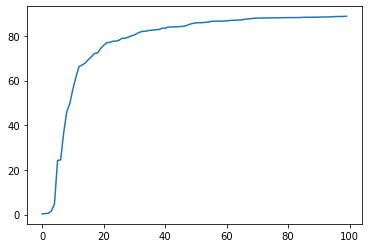

In [40]:
q=list(theta*180/3.14)
q.sort()
print(q)
plt.plot(q)

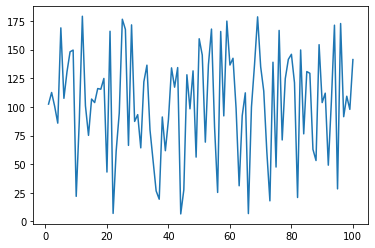

In [41]:
n=np.linspace(1,100,100)
plt.plot(n,phi*180/3.14)

tan_theta=energyx/energy1y
cos_phi=energyz/energy2

# taking a look at the atual data available and the data interprited

In [57]:
x_pos=np.array(pd.read_csv('recx_pos.csv'))

y_pos=np.array(pd.read_csv('recy_pos.csv'))


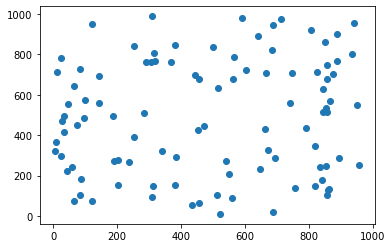

In [206]:
plt.scatter(x_pos,y_pos)

In [58]:
dist_act=np.sqrt((x_pos-500)**2+(y_pos-500)**2)

In [59]:
dist_act
dist_act=dist_act.reshape(len(dist_act))


In [133]:
energy_tot=energy_rec_x+energy_rec_y+energy_rec_z

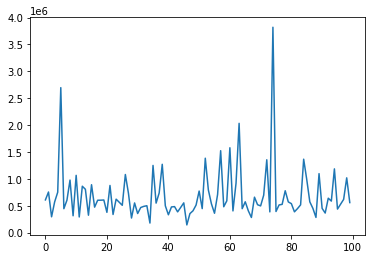

In [134]:
plt.plot(energy_tot[0])

In [220]:
fit=np.polyfit(np.log(energy_tot[0]),np.log(abs(dist_act)),1)


Text(0, 0.5, 'energy')

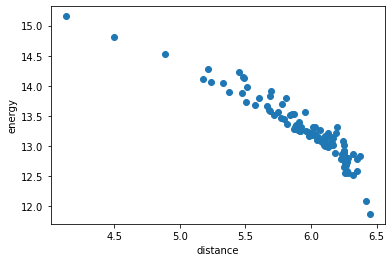

In [164]:
plt.scatter(np.log(abs(dist_act)),np.log(energy_tot[0]))
plt.xlabel('distance')
plt.ylabel('energy')

# plot of 1/distance and energy recieved by the recievers

In [121]:
(abs(dist_act[1:])/(abs((energy_tot[0][0]/energy_tot[0][1:])-1)))

<ipython-input-121-8a7fba8ae883>:1: RuntimeWarning: divide by zero encountered in true_divide
  (abs(dist_act[1:])/(abs((energy_tot[0][0]/energy_tot[0][1:])-1)))


array([  6.48376065e+06,   5.67687156e+06,   8.93311654e+06,
         1.24142876e+07,   1.47506041e+07,   1.53843169e+07,
         1.38479503e+07,   3.94372054e+06,   6.17563887e+06,
         3.61903590e+06,   4.02734563e+06,   4.02734563e+06,
         3.61903590e+06,   6.17563887e+06,   3.94372054e+06,
         1.38479503e+07,   1.53843169e+07,   1.47506041e+07,
         1.24142876e+07,   8.93311654e+06,   5.67687156e+06,
         6.48376065e+06,              inf,   7.49308846e+07,
         4.63506635e+05,   2.33473432e+05,   1.49290664e+05,
         1.08749787e+05,   8.43634060e+04,   6.74770790e+04,
         5.54985156e+04,   4.65753496e+04,   4.00634923e+04,
         3.44193875e+04,   3.01932622e+04,   2.68894523e+04,
         2.37815778e+04,   2.13388915e+04,   1.91833014e+04,
         1.75031413e+04,   1.59503060e+04,   1.46443212e+04,
         1.35944916e+04,   1.25949806e+04,   1.17761427e+04,
         1.11093735e+04,   1.04850484e+04,   1.00300134e+04,
         9.64305121e+03,

actual angle of the reciever and the source

In [53]:
theta1=np.arctan((y_pos-500)/(x_pos-500))

<ipython-input-53-d4e752dd58f1>:1: RuntimeWarning: divide by zero encountered in true_divide
  theta1=np.arctan((y_pos-500)/(x_pos-500))


comparision between actual and calculated angle

In [54]:

q1=list(theta1*180/3.14)
q1.sort()
for i in range(len(q1)):
    q1[i]=float(q1[i])   
q1=np.array(q1)
q=np.array(q)
plt.plot((theta1-theta)*180/3.14)



NameError: name 'q' is not defined

In [55]:
for i in range(len(theta1)):
    theta1[i]=float(theta1[i][0]) 
for i in range(len(theta)):
    theta[i]=float(theta[i,0])    

NameError: name 'theta' is not defined

In [56]:
theta2=theta1[:,0]
theta3=theta[:,0]
print(theta2)

NameError: name 'theta' is not defined

In [57]:
theta=np.array(theta)
theta1=np.array(theta1)

NameError: name 'theta' is not defined

In [58]:
plt.plot((theta2-theta3)*180/3.14)

NameError: name 'theta3' is not defined

In [59]:
event_accuracy=[]

# to check the accuracy of event detector

In [60]:
for i in range(len(rec_data)):
    event_accuracy.append(np.mean(event2[i]-rec_data[i]))

# compariosion between total energy amd energy in all 3 axis squared and added

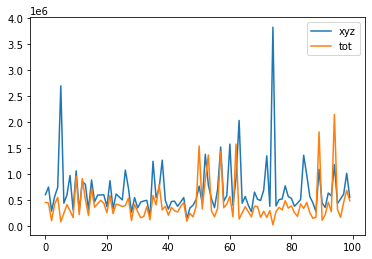

In [135]:
plt.plot((energy_rec_x[0]+energy_rec_y[0]+energy_rec_z[0]))
plt.plot(energy_rec_tot[0])
plt.legend(['xyz','tot'])

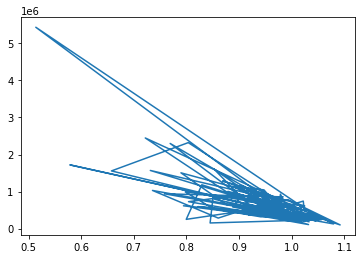

In [62]:
plt.plot((dist_act** 0.32500112)*0.13420076151,(energy_rec_tot[0]))

In [63]:

energy_rec_tot[0].sort()

In [64]:
sorted_dist=[]
sorted_energy=[]
for i in range(len(dist_act)):
    sorted_dist.append(dist_act[i][0])
    sorted_energy.append(energy_rec_tot[0][i])

In [65]:
sorted_distance.sort()
sorted_energy.sort()

NameError: name 'sorted_distance' is not defined

In [66]:
dist_act_arranged=np.array(sorted_dist)
energy_tot=np.array(sorted_energy)

In [52]:
energy_tot

array([[  1.05861372e+11,   1.06094075e+11,   1.06127303e+11,
          1.06030252e+11,   1.05982867e+11,   1.05963624e+11,
          1.05763501e+11,   1.05752639e+11,   1.05480509e+11,
          1.05617819e+11,   1.05446417e+11,   1.05488328e+11,
          1.05488328e+11,   1.05446417e+11,   1.05617819e+11,
          1.05480509e+11,   1.05752639e+11,   1.05763501e+11,
          1.05963624e+11,   1.05982867e+11,   1.06030252e+11,
          1.06127303e+11,   1.06094075e+11,   1.05861372e+11,
          1.05841295e+11,   1.02712785e+11,   9.97904931e+10,
          9.66676070e+10,   9.36400884e+10,   9.06211595e+10,
          8.74759222e+10,   8.43223926e+10,   8.11667263e+10,
          7.82104001e+10,   7.50076216e+10,   7.20777698e+10,
          6.93687975e+10,   6.63894776e+10,   6.36830860e+10,
          6.09655398e+10,   5.85921539e+10,   5.61626016e+10,
          5.39169302e+10,   5.19594383e+10,   4.99521200e+10,
          4.81929839e+10,   4.66770447e+10,   4.51826267e+10,
        

# figuring the power law and relation between the distance and the enegry from actual data

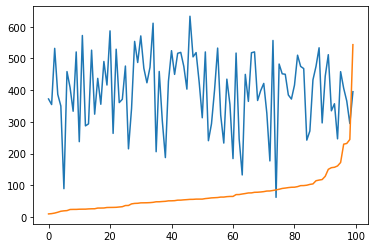

In [68]:
plt.plot(sorted_dist)
plt.plot(energy_tot/10000)

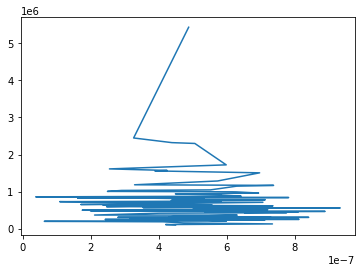

In [69]:
plt.plot((dist_act_arranged** 1.37791931)*1.2877589e-10,energy_tot)

In [70]:
poly_coeff=np.polyfit(np.log(dist_act_arranged),np.log(energy_tot),1)

In [71]:
poly_coeff

array([ -0.02444985,  13.39313578])

In [72]:
dist_act_arranged

array([ 372.22842449,  354.66322053,  531.7527621 ,  386.64841911,
        350.04285452,   89.58794562,  458.541165  ,  408.57435064,
        333.58806933,  520.43251244,  237.67414668,  572.24208164,
        287.43347056,  293.81967259,  526.03136789,  324.32237049,
        437.21962445,  355.53480842,  490.40799341,  416.20307543,
        586.8091683 ,  263.78210705,  528.98582212,  360.85592693,
        371.28021763,  476.01785681,  215.14878573,  342.37406444,
        553.61538996,  487.19811165,  570.93782499,  468.93176476,
        423.2646926 ,  472.12816057,  610.96644752,  206.041258  ,
        458.91720386,  303.91610685,  187.54466135,  428.04906261,
        524.41205173,  449.72213644,  516.07170044,  519.06165337,
        474.82628402,  403.27905971,  632.927326  ,  504.94554162,
        518.41778519,  424.59039085,  313.05750271,  520.44980546,
        240.75298544,  294.04931559,  400.82415097,  532.58051035,
        320.91431878,  233.28308983,  434.68724389,  355.23794

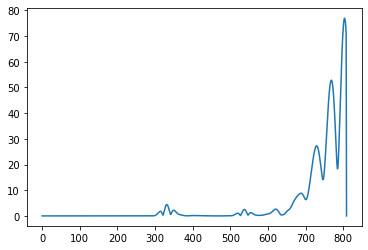

In [128]:
plt.plot(rec_data[2])
#plot(abs(recx_data[0]))
#plt.plot(abs(recy_data[0]))
#plt.plot(abs(recz_data[0]))
#plt.legend(['tot','x','y','z'])

In [62]:
time[on1[0]]

array([[ 508.]])

In [60]:
dist[:]

array([   0.        ,  -24.72187886,  160.69221261,   12.36093943,
       -131.02595797, -420.27194067,   -2.47218789,  -46.97156984,
       -148.33127318,  148.33127318, -252.1631644 ,  103.83189122,
        -88.99876391, -190.35846724,   66.74907293,  -51.91594561,
         -2.47218789,  -34.61063041,  131.02595797,   46.97156984,
        118.66501854, -111.24845488,  158.22002472,  -93.94313968,
        -14.83312732,   22.24969098, -135.97033375,  -49.44375773,
         88.99876391,  118.66501854,  103.83189122,   96.41532756,
        -54.3881335 ,   98.88751545,  145.85908529, -279.35723115,
        -14.83312732,  -69.22126082, -190.35846724,  -24.72187886,
         59.33250927,    0.        ,  145.85908529,  148.33127318,
         27.19406675,  -44.49938195,  264.52410383,  133.49814586,
        148.33127318,   49.44375773,  -12.36093943,   51.91594561,
       -249.69097651,  -79.11001236,  -74.16563659,   71.6934487 ,
       -163.16440049, -140.91470952,   61.80469716,  -37.08281

In [335]:
print((dist_act[:,0]))


[ 372.22842449  354.66322053  531.7527621   386.64841911  350.04285452
   89.58794562  458.541165    408.57435064  333.58806933  520.43251244
  237.67414668  572.24208164  287.43347056  293.81967259  526.03136789
  324.32237049  437.21962445  355.53480842  490.40799341  416.20307543
  586.8091683   263.78210705  528.98582212  360.85592693  371.28021763
  476.01785681  215.14878573  342.37406444  553.61538996  487.19811165
  570.93782499  468.93176476  423.2646926   472.12816057  610.96644752
  206.041258    458.91720386  303.91610685  187.54466135  428.04906261
  524.41205173  449.72213644  516.07170044  519.06165337  474.82628402
  403.27905971  632.927326    504.94554162  518.41778519  424.59039085
  313.05750271  520.44980546  240.75298544  294.04931559  400.82415097
  532.58051035  320.91431878  233.28308983  434.68724389  355.23794842
  184.32851109  516.90714834  246.13004693  132.84953895  449.72213644
  364.62172179  517.8725712   520.57084052  367.46156262  398.46957224
  421.

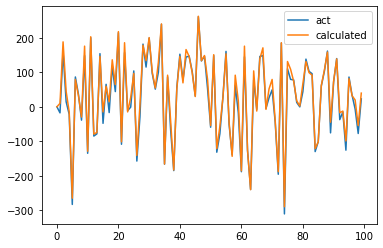

In [80]:
plt.plot(dist_act-dist_act[0])
plt.plot(dist)
plt.legend(['act','calculated'])

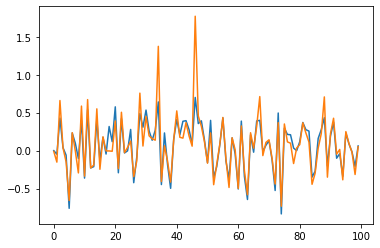

In [158]:
plt.plot((dist_act/dist_act[0])-1)
plt.plot(0.98943872606*(np.power(energy_tot[0]/energy_tot[0][0],- 0.71056748))-1)

In [163]:
np.mean(((dist_act[1:]-dist_act[0]))/((0.98943872606*(np.power(energy_tot[0][1:]/energy_tot[0][0],- 0.71056748))-1)))

-19.591891252939568

In [180]:
fit_coeff=np.polyfit(np.sort(np.log(energy_tot[0][0]/energy_tot[0])),np.sort(np.log(dist_act)),10)

In [181]:
fit_coeff

array([ 0.21748823,  0.32698737, -1.09917101, -1.47706815,  1.95865972,
        2.19148187, -1.50172632, -1.21057524,  0.26769409,  0.84214305,
        5.93454594])

In [182]:
dist_energy=np.exp(np.polyval(fit_coeff,np.sort(np.log(energy_tot[0][0]/energy_tot[0]))))

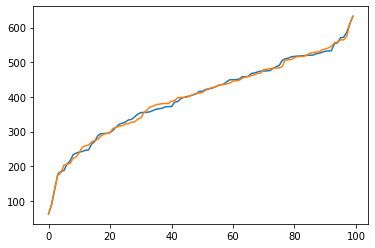

In [183]:
plt.plot(np.sort(dist_act))
plt.plot(dist_energy)

In [81]:
(dist/(dist_act-dist_act[0]))

<ipython-input-81-2020a8131db7>:1: RuntimeWarning: invalid value encountered in true_divide
  (dist/(dist_act-dist_act[0]))


array([         nan,  -0.56297391,   1.17779069,   3.08594997,
         0.66859347,   0.93590311,   0.91655081,   0.88423782,
         0.76775316,   1.18434884,   0.95540456,   1.01352782,
         0.93295661,   0.94588467,   0.94835042,   0.3096295 ,
         0.91293143,  -0.88855088,   1.15054011,   1.46168039,
         1.01384929,   0.93465325,   1.1828092 ,   1.30429813,
       -28.67946616,   0.9289513 ,   0.89709087,  -0.16561654,
         0.98131377,   1.16115951,   1.00773903,   1.04815101,
         1.06567615,   1.28682793,   1.00445761,   0.996687  ,
         1.05516484,   0.61522132,   0.99056842,   0.9300493 ,
         0.95844138,   0.89325003,   1.15150734,   0.99336565,
         0.96383605,   0.95541539,   1.00518995,   1.00588491,
         1.01465163,   1.51082967,   0.91916995,   1.01742043,
         0.92136757,   0.72730838,   0.95098359,   0.95586938,
         0.8671959 ,   1.03196626,   1.46450017,  -1.01853033,
         0.9867705 ,   1.21320769,   0.99986681,   1.00

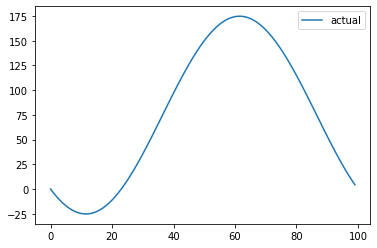

In [178]:
plt.plot(dist_act[:]-dist_act[0])
#plt.plot(dist/2)
plt.legend(['actual','calculated'])

In [347]:
dist_act/372

array([[ 1.00061404],
       [ 0.95339575],
       [ 1.42944291],
       [ 1.03937747],
       [ 0.94097542],
       [ 0.24082781],
       [ 1.23263754],
       [ 1.09831815],
       [ 0.89674212],
       [ 1.39901213],
       [ 0.638909  ],
       [ 1.53828517],
       [ 0.77267062],
       [ 0.78983783],
       [ 1.41406282],
       [ 0.87183433],
       [ 1.17532157],
       [ 0.95573873],
       [ 1.31830106],
       [ 1.11882547],
       [ 1.577444  ],
       [ 0.70909169],
       [ 1.4220049 ],
       [ 0.97004281],
       [ 0.9980651 ],
       [ 1.27961789],
       [ 0.57835695],
       [ 0.92036039],
       [ 1.48821341],
       [ 1.30967234],
       [ 1.5347791 ],
       [ 1.26056926],
       [ 1.13780831],
       [ 1.26916172],
       [ 1.64238292],
       [ 0.55387435],
       [ 1.2336484 ],
       [ 0.81697878],
       [ 0.50415232],
       [ 1.15066952],
       [ 1.40970982],
       [ 1.20893047],
       [ 1.38728952],
       [ 1.39532703],
       [ 1.27641474],
       [ 1

In [129]:
@widgets.interact(p=(1,3,0.001))
def energy_dist(p):
    #plt.plot((np.power((energy_tot[0][0]/energy_tot[0]),1/2.64)))
    plt.scatter((dist_act),(np.power((1/energy_tot[0]),1/2.796)))
    mean_distance=np.mean((dist_act[1:].reshape(len(dist_act[1:])))/(np.power((energy_tot[0][0]/energy_tot[0,1:]),1/2.796)))
    print(mean_distance)
    #plt.legend(['energy','distance'])

interactive(children=(FloatSlider(value=2.0, description='p', max=3.0, min=1.0, step=0.001), Output()), _dom_c…

In [130]:
@widgets.interact(p=(1,3,0.01))
def comp(p):
    plt.plot(np.power(np.sort(energy_tot[0][0]/energy_tot[0]),1/p))
    plt.plot(np.sort(dist_act.reshape(len(dist_act)))/372.22842449)

interactive(children=(FloatSlider(value=2.0, description='p', max=3.0, min=1.0, step=0.01), Output()), _dom_cl…

In [71]:
dist_act[0][0]

372.22842449227329

In [72]:
mean_distance=np.mean((dist_act[1:].reshape(len(dist_act[1:])))/(np.power((energy_tot[0][0]/energy_tot[0,1:]),1/2.64)))

In [66]:
mean_distance

370.94608649814444

In [67]:
(dist_act[1:].reshape(len(dist_act[1:])))/(np.power((energy_tot[0][0]/energy_tot[0,1:]),1/2.64))

array([ 379.55909952,  387.33109937,  369.66737614,  371.11172132,
        150.98983557,  403.54060883,  406.1050175 ,  390.25121939,
        401.98502545,  282.96533544,  418.65555411,  314.34251171,
        319.55837233,  404.56128227,  361.77951544,  398.91947119,
        342.2134699 ,  481.60827972,  413.58309823,  469.81688582,
        290.24534496,  404.96057258,  349.36997744,  349.44912018,
        467.61628023,  256.23362677,  352.6844966 ,  391.90292664,
        449.96294524,  448.5550769 ,  409.12265798,  381.36310267,
        442.49913295,  370.27241789,  259.52982443,  424.32969215,
        320.1974992 ,  237.52371102,  392.30070595,  404.95874464,
        433.97370296,  467.72394657,  422.47036053,  429.44660754,
        381.77617884,  350.81774691,  397.84126389,  427.69660027,
        389.73515474,  328.52115348,  445.36812356,  314.97922237,
        312.82839885,  365.19629023,  467.52195271,  327.08306015,
        316.46545185,  384.96662957,  336.77845817,  253.42600

In [ ]:
fit_relation=np.polyfit(np.log((dist_act/372.22842449).reshape(len(dist_act))),np.log(energy_tot[0][0]/energy_tot[0]),1)

In [75]:
fit_relation

array([ 1.30273603,  0.07513522])

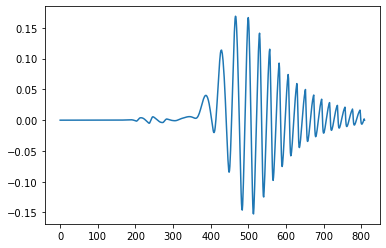

In [238]:
plt.plot(rec_data[1]-rec_data[0])

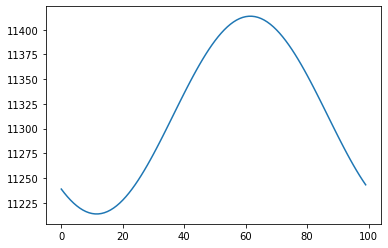

In [146]:
plt.plot(dist_act)


Text(0.5, 0, 'reciever number')

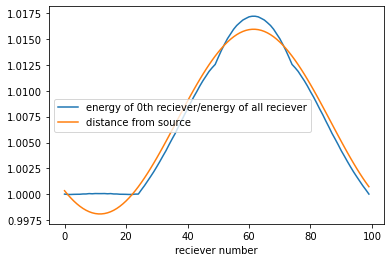

In [159]:
plt.plot(np.power((energy_tot[0][1]/energy_tot[0]),0.01380235))
plt.plot((dist_act.reshape(len(dist_act)))/dist_act[1])
plt.legend(['energy of 0th reciever/energy of all reciever','distance from source'])
plt.xlabel('reciever number')

In [155]:
np.mean(dist_act/np.power((energy_tot[0][0]/energy_tot[0]),0.01380235))

11235.055841844915

In [75]:
from scipy import*

In [76]:
func()

NameError: name 'func' is not defined

In [59]:
poly_coeff=np.polyfit(dist_act.reshape(len(dist_act)),1/energy_tot[0],10)

E:\conda\envs\tf-n-gpu\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


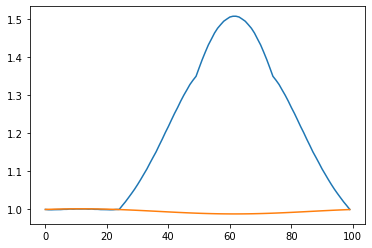

In [71]:
plt.plot((energy_tot[0][0]/energy_tot[0]))
plt.plot(dist_act/dist_act[0])

In [60]:
poly_coeff

array([ -2.30700778e-44,   6.87691628e-40,   1.67681105e-36,
        -1.01618883e-31,  -1.50377145e-27,   1.09881833e-25,
         3.34096298e-19,   4.94155490e-15,  -1.87532935e-11,
        -1.64237187e-06,   1.22403999e-02])

In [61]:
en=np.polyval(poly_coeff,dist_act.reshape(len(dist_act)))

In [62]:
energy_tot[0][0]

105861371603.539

In [63]:
dist_act

array([ 14924.40002884,  14928.38372575,  14932.05625449,  14935.40335583,
        14938.4120432 ,  14941.07065043,  14943.3688746 ,  14945.29781382,
        14946.84999968,  14948.01942459,  14948.80156361,  14949.19339095,
        14949.19339095,  14948.80156361,  14948.01942459,  14946.84999968,
        14945.29781382,  14943.3688746 ,  14941.07065043,  14938.4120432 ,
        14935.40335583,  14932.05625449,  14928.38372575,  14924.40002884,
        14920.12064294,  14915.56220994,  14910.74247254,  14905.68020809,
        14900.39515836,  14894.90795527,  14889.24004306,  14883.41359695,
        14877.45143875,  14871.3769495 ,  14865.21397957,  14858.98675655,
        14852.71979117,  14846.43778167,  14840.16551689,  14833.92777863,
        14827.74924343,  14821.6543843 ,  14815.66737282,  14809.81198194,
        14804.11148985,  14798.58858556,  14793.26527627,  14788.16279724,
        14783.3015244 ,  14778.70089013,  14774.37930267,  14770.35406944,
        14766.64132472,  

In [64]:
np.mean(energy_tot[0][0]*(abs(1/((1.44749660e-003*dist_act.reshape(len(dist_act)))-2.13810964e-002)))/energy_tot[0])

0.08564238280012082

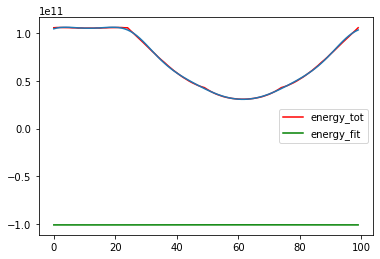

In [65]:
plt.plot(energy_tot[0],color='red')
plt.plot(energy_tot[0][0]*(abs(1/(1.44749660e-003*dist_act-2.13810964e-002))-1),color='green')
plt.plot(abs(1/en))
plt.legend(['energy_tot','energy_fit'])

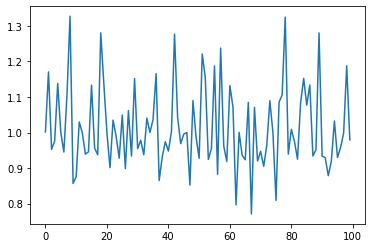

In [172]:
plt.plot(abs(energy_tot[0]*en))

In [206]:
dist

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [68]:
plt.plot((((1/((energy_tot[0]/energy_tot[0][0])+1))+2.13810964e-002)/1.44749660e-003))
plt.plot(dist_act)
plt.legend(['estimated distance','actual distance'])

NameError: name 'energy_tot' is not defined

In [134]:
estimated_distance=(((1/((energy_tot[0]/energy_tot[0][0])+1))+2.13810964e-002)/1.44749660e-003)

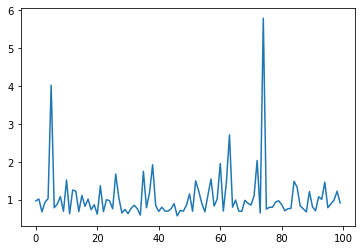

In [136]:
plt.plot(estimated_distance[0]/dist_act)

In [210]:
estimated_distance-dist_act[0]

array([ -12.03338403,  -49.14322478,  108.37483762,   -0.94880019,
        -48.29995241, -230.49008716,   41.65534406,  -10.37595703,
        -92.32279466,   98.67506668, -106.27315364,  109.96658728,
        -71.70587227,  -60.24289941,   93.58394307,  -77.04963499,
         31.00238702,  -10.21193136,  -10.46830816,  -11.44135793,
         69.07717896,  -74.45664045,   87.0628517 ,  -15.86417459,
          0.70425731,   19.04365041, -108.57057006,  -44.36621569,
        120.39867669,    4.87773996,   78.75147562,   33.5389897 ,
         25.83930887,   21.81235251,  177.26022104, -131.21778974,
          5.82341473,  -44.9690864 , -133.77462629,   22.05714985,
         89.6973165 ,   29.71918079,   27.43434611,   65.35924598,
         33.04007953,    4.44360649,  201.95209481,   79.63066208,
         57.18326424,   17.78770039,  -53.13075433,   41.12150255,
       -146.46810743,  -57.49269233,   10.26202041,   76.62210503,
        -38.18784252, -160.29720583,   28.42676716,   -6.99883